#### In this notebook, we will do the following steps in order:

- Load and normalizing the CIFAR10 training and test datasets using torchvision
- Define a Convolutional Neural Network
- Define a loss function
- Train the network on the training data
- Test the network on the test data

In [1]:
!pip install torchvision

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


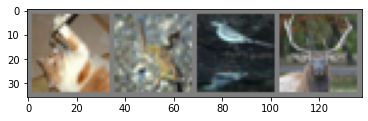

  cat  frog  bird  deer


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [5]:
# Define a Convolutional Neural Network
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [6]:
# Define a Loss function and optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
# Train the network
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # compute gradients
        loss.backward()
        
        # update weights using Stochastic Gradient Descent (SGD)
        # weight = weight - learning_rate * gradient
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.225
[1,  4000] loss: 1.854
[1,  6000] loss: 1.683
[1,  8000] loss: 1.573
[1, 10000] loss: 1.504
[1, 12000] loss: 1.460
[2,  2000] loss: 1.376
[2,  4000] loss: 1.356
[2,  6000] loss: 1.314
[2,  8000] loss: 1.285
[2, 10000] loss: 1.263
[2, 12000] loss: 1.263
Finished Training


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

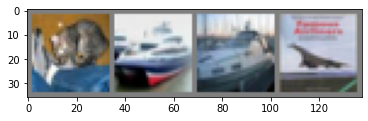

GroundTruth:    cat  ship  ship plane


In [9]:
# Test the network on the test data
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
# Output energies for the 10 classes
outputs = net(images)
print(outputs)

tensor([[-1.1867, -1.5574,  0.4826,  2.8602, -0.1500,  2.7788,  0.2752,  0.1414,
         -1.2711, -1.2562],
        [ 5.7304,  7.0436, -2.3627, -3.6012, -2.3478, -5.1868, -4.6112, -5.2146,
          5.1848,  4.2607],
        [ 2.8133,  1.6646, -0.0512, -1.6071,  0.0916, -2.1596, -2.3306, -1.7150,
          1.7685,  0.9349],
        [ 5.3408,  1.4681,  0.5213, -1.6971, -0.7341, -3.4228, -2.1215, -3.9367,
          3.7264,  0.7123]], grad_fn=<AddmmBackward>)


In [12]:
# Get the index of the highest energy
_, predicted = torch.max(outputs, 1)
print(predicted)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

tensor([3, 1, 0, 0])
Predicted:    cat   car plane plane


In [13]:
correct = 0
total = 0
with torch.no_grad():
    i = 0
    for data in testloader:
        i += 1
        images, labels = data
        outputs = net(images)
        
        
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()
        

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %
